In [163]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
LEFTOUT_BGC = 'BGC0001482' # This BGC doesn't have metadata, for some reason.

In [3]:
mibig_counts_df = pd.read_csv('mibig_table.tsv', sep='\t')
mibig_counts_df = mibig_counts_df[mibig_counts_df['BGC'] != LEFTOUT_BGC]
mibig_counts = mibig_counts_df.to_numpy()[:, 1:17]
pfam_colnames = mibig_counts_df.columns[1:17]

mibig_uniques = mibig_counts.astype(bool).astype(int) 

bgc_counts = np.sum(mibig_counts, axis=1)
bgc_unique_counts = np.sum(mibig_uniques, axis=1)

In [220]:
antismash_counts_df = pd.read_csv('antismash_table.tsv', sep='\t')
antismash_counts = antismash_counts_df.to_numpy()[:, 0:15]

In [30]:
antismash_counts.astype(float).shape

(189423, 14)

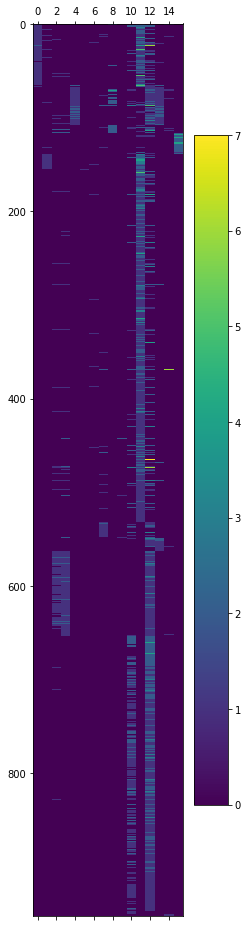

In [86]:
plt.matshow(mibig_counts.astype(float), aspect=0.1)
plt.colorbar()
plt.show()

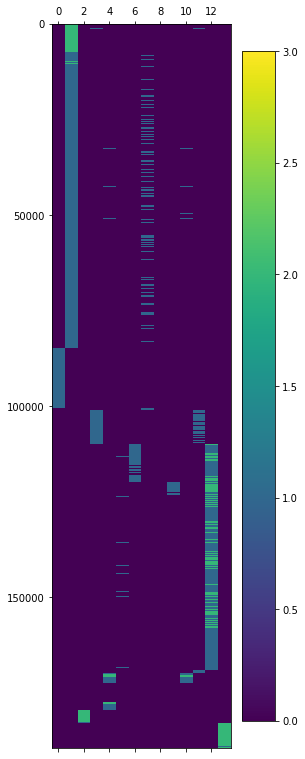

In [85]:
plt.matshow(antismash_counts.astype(float), aspect=0.0003)
plt.colorbar()
plt.show()

In [75]:
from sklearn.decomposition import PCA

In [76]:
pca = PCA(n_components=2)

In [78]:
mibig_pca = pca.fit_transform(mibig_counts)
antismash_pca = pca.fit_transform(antismash_counts)

In [82]:
mibig_pca.shape

(953, 2)

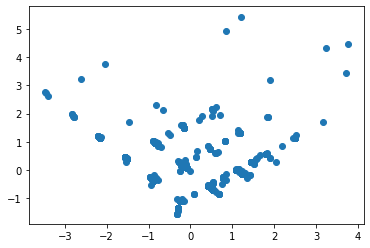

In [79]:
plt.scatter(mibig_pca[:, 0], mibig_pca[:, 1])

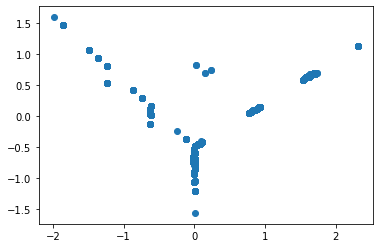

In [80]:
plt.scatter(antismash_pca[:, 0], antismash_pca[:, 1])

In [89]:
# Load the metadata and filter to ones with transporters

_mibig_meta = pd.read_csv('data_mibig_fixed.tsv', sep='\t') # Lots of stuff with no transporters present
mibig_meta = _mibig_meta[_mibig_meta['BGC'].isin(mibig_counts_df['BGC'])].reset_index(drop=True)

# Make sure mibig_meta and mibig_counts_df agree have same index
# There should be a clean pandas way to do this, but shrug

# Create dict with mibig_counts_df order
int_to_bgc = dict(enumerate(mibig_counts_df['BGC']))
bgc_to_int = {v: k for k,v in int_to_bgc.items()}

# Now add this column unordered to mibig_meta and sort it
mibig_meta['idx'] = [bgc_to_int[name] for name in mibig_meta['BGC']]
mibig_meta = mibig_meta.sort_values(by='idx', ascending=True)

# Now drop the idx column and reset index
mibig_meta = mibig_meta.drop(columns='idx')
mibig_meta = mibig_meta.reset_index(drop=True)

assert list(mibig_meta['BGC']) == list(mibig_counts_df['BGC']), 'BGC of metadata and counts do not agree. Check ordering.'

In [93]:
mibig_counts.shape

(953, 16)

In [92]:
mibig_meta['Antibacterial']

0      0
1      0
2      0
3      0
4      0
      ..
948    0
949    0
950    0
951    0
952    0
Name: Antibacterial, Length: 953, dtype: int64

In [120]:
traits_of_interest = ['Antibacterial', 'Antifungal', 'Siderophore', 'Gram']

In [221]:
antismash_counts

array([[0, 0, 3, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=object)

In [216]:
antismash_counts_df.columns[1:16]

Index(['acr', 'tonb_rec', 'abc_tran', 'matE', 'abc_mem2', 'ftsx', 'mfs2',
       'mfs3', 'abc_mem', 'mfs5', 'mfs4', 'macb', 'abc_mem3', 'mfs', 'oep'],
      dtype='object')

In [215]:
antismash_counts

array([[0, 3, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=object)

In [223]:
display = antismash_counts
plt.figure(figsize=(100,50))
plt.matshow(display.astype(float), aspect=0.0005, fignum=0)
plt.tick_params(axis='x', labelbottom='true')
plt.xticks(np.arange(16), labels=antismash_counts_df.columns[1:16], rotation=45, fontsize=12)
plt.colorbar()
plt.title('Antismash Raw Counts', fontsize=20)
plt.savefig(f'antismash_raw_data_plot.png')
plt.close()

In [203]:
def plot_trait_and_mibig(count_matrix: np.ndarray,
                         trait: np.ndarray,
                         trait_names: List[str],
                         title: str,
                         trait_name: str) -> None:
    idx = trait.argsort()[::-1] # Sort from top to bottom trait value
    sorted_trait = trait[idx]
    cutoffs = [np.min(np.where(np.squeeze(sorted_trait) == i)) for i in np.unique(trait)][::-1]
    display = count_matrix[idx]
    plt.figure(figsize=(100,50))
    plt.matshow(display.astype(float), aspect=0.1, fignum=0)
    plt.tick_params(axis='x', labelbottom='true')
    plt.xticks(np.arange(16), labels=pfam_colnames, rotation=45, fontsize=12)
    plt.colorbar()
    plt.hlines(cutoffs, -0.9, 20)
    for i, name in enumerate(trait_names):
        if i < len(trait_names) - 1:
            y = (cutoffs[i] + cutoffs[i+1])/2
        else:
            y = (count_matrix.shape[0] + cutoffs[i])/2
        plt.text(16, y, name, fontsize=18)
    plt.title(title, fontsize=20)
    plt.savefig(f'raw_data_plot_{trait_name}.png')
    plt.close()

In [165]:
list(set(mibig_meta['Type']))

['Head-to-tailcyclized peptide',
 'Alkaloid',
 'Microviridin',
 'Lap / Microcin',
 'Other',
 'Saccharide',
 'Sactipeptide',
 'RiPP',
 'lantipeptide',
 'Nucleoside',
 'Polyketide',
 'Cyanobactin',
 'Terpene',
 'Lap',
 'Linaridin',
 'Thiopeptide',
 'Lasso Peptide',
 'LAP',
 'NRP',
 'Microcin',
 'Head-To-Tail Cyclized Peptide',
 'Lassopeptide',
 'Bottromycin',
 'Lantipeptide']

In [175]:
trait_names = {'Antibacterial': ['Antibacterial', 'Not Antibacterial'],
               'Antifungal': ['Antifungal', 'Not Antifungal'],
               'Siderophore': ['Siderophore', 'Not Siderophore'],
               'Gram': ['Other', 'Fungi', 'Gram Positive', 'Gram Negative']
              }

In [204]:
for trait in traits_of_interest:
    trait_array = np.array(mibig_meta[trait])
    plot_trait_and_mibig(mibig_counts, trait_array, trait_names[trait], f'MIBIG counts sorted by {trait}', trait)